In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, distinct, alias, desc, join, extract

In [5]:
#Creating engine using hawaii.sqlite database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

# Exploratory Climate Analysis

* Design a query to retrieve the last 12 months of precipitation data and plot the results

* Calculate the date 1 year ago from the last data point in the database

* Perform a query to retrieve the data and precipitation scores

* Save the query results as a Pandas DataFrame and set the index to the date column

* Sort the dataframe by date

* Use Pandas Plotting with Matplotlib to plot the data


In [11]:
latest_date = session.query(Measurement.date).\
              order_by(Measurement.date.desc()).first()
latest = dt.date(2017,8,23)
print(latest)

2017-08-23


In [12]:
date_yr = dt.date(2017,8,23) - dt.timedelta(days=365)
date_yr

datetime.date(2016, 8, 23)

In [13]:
results = session.query(Measurement.date,Measurement.prcp).\
          filter(Measurement.date > date_yr).\
          order_by(Measurement.date.desc()).all()

prcp_df = pd.DataFrame(results, columns=['Date','Precipitation'])
prcp_df = prcp_df.set_index('Date')

prcp_df = prcp_df.sort_values(by=['Date'],ascending=True)

prcp_df.head()

,Precipitation
Date,
2016-08-24,1.45
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.15
2016-08-24,NaN


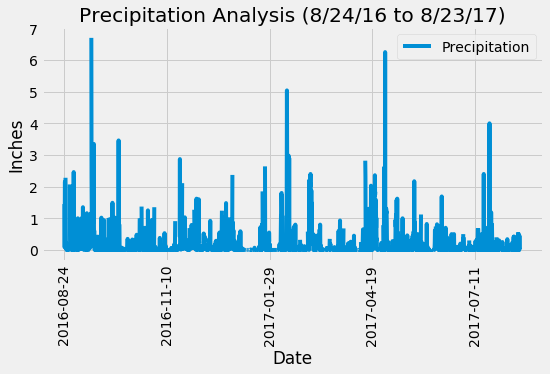

In [14]:
ax = prcp_df.plot(figsize=(8,4),rot=90)
ax.set_title("Precipitation Analysis (8/24/16 to 8/23/17)")
ax.set_ylabel('Inches')
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data

prcp_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analysis

In [16]:
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [17]:
# Design a query to show how many stations are available in this dataset?

#session.query(func.count(distinct(Measurement.station))).all()

result_station = session.query(func.count(Station.station)).all()
print(f'Stations available in the dataset{result_station}')

Stations available in the dataset[(9,)]


In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station,func.count(Measurement.station)).\
group_by(Measurement.station).\
order_by(desc(func.count(Measurement.station))).\
all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# running the previous query again, using join statement to get the names of the station as well.

session.query(Measurement.station,Station.name,func.count(Measurement.station)).\
filter(Measurement.station==Station.station).\
group_by(Measurement.station).\
order_by(desc(func.count(Measurement.station))).\
all()

[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

session.query(func.max(Measurement.tobs),func.min(Measurement.tobs),func.avg(Measurement.tobs)).\
filter(Measurement.station=='USC00519281').all()

[(85.0, 54.0, 71.66378066378067)]

In [21]:
# Choose the station with the highest number of temperature observations.
session.query(Measurement.station,func.count(Measurement.tobs)).\
               group_by(Measurement.station).\
               order_by(desc(func.count(Measurement.tobs))).first()

('USC00519281', 2772)

In [22]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_observation = session.query(Measurement.station,Measurement.tobs,Measurement.date).\
                   filter(Measurement.station=='USC00519281').\
                   filter(Measurement.date > date_yr).all()

temp_df = pd.DataFrame(temp_observation, columns=['Station','Temperature','Date'])
temp_df.head()

,Station,Temperature,Date
0,USC00519281,77.0,2016-08-24
1,USC00519281,80.0,2016-08-25
2,USC00519281,80.0,2016-08-26
3,USC00519281,75.0,2016-08-27
4,USC00519281,73.0,2016-08-28


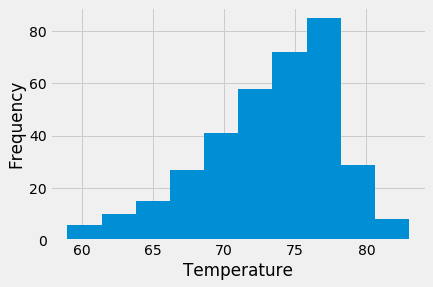

In [23]:
plt.hist(temp_df['Temperature'], density=False)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

## Bonus Challenge Assignment

In [48]:
# Temperature Analysis-I
result_june = session.query(func.avg(Measurement.tobs)).filter(extract('month', Measurement.date)==6).all()
result_dec = session.query(func.avg(Measurement.tobs)).filter(extract('month', Measurement.date)==12).all()

list_june = session.query(Measurement.tobs).filter(extract('month', Measurement.date)==6).all()
list_dec = session.query(Measurement.tobs).filter(extract('month', Measurement.date)==12).all()


avg_june = result_june[0][0]
avg_dec = result_dec[0][0]

print(f'Avg temp for june {avg_june} and Avg temp for Dec {avg_dec}')

Avg temp for june 74.94411764705882 and Avg temp for Dec 71.04152933421226


In [49]:
# unpaired t-test as we want to independently determine the difference between the temperature in June and December

un_paired = stats.ttest_ind(list_june,list_dec)
print(f'un_paired{un_paired}')

un_pairedTtest_indResult(statistic=array([31.60372399]), pvalue=array([3.9025129e-191]))


In [31]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        "end_date (string): A date string in the format %Y-%m-%d"
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28','2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [51]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

#Trip dates-2018/07/20 to 2018/08/10

trip_avg_temp=calc_temps('2017-07-20','2017-08-10')
trip_avg_temp

[(71.0, 78.87068965517241, 84.0)]

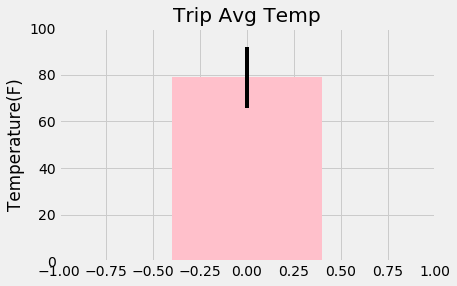

In [58]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

y_error_bar =trip_avg_temp[0][2]-trip_avg_temp[0][0]
y=trip_avg_temp[0][1]
x=0

plt.bar(x,y,color='pink',yerr=y_error_bar)
plt.ylabel("Temperature(F)")
plt.title("Trip Avg Temp")
plt.xlim(-1, 1)
plt.ylim(0, 100)
plt.show()

In [82]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

arrival_date = dt.date(2018,7,20)
depart_date = dt.date(2018,8,10)

#finding matching dates yearback
year_back_date1 = arrival_date - dt.timedelta(days=365)
year_back_date2 = depart_date - dt.timedelta(days=365)

stmt = session.query(Station.name,Measurement.prcp,Station.latitude,Station.longitude,Station.elevation).\
       filter(Measurement.station == Station.station).\
       filter(Measurement.date >= year_back_date1).\
       filter(Measurement.date <= year_back_date2).\
       group_by(Station.name).\
       order_by(desc(Measurement.prcp)).statement

prcp_df2 = pd.read_sql_query(stmt,session.bind)
prcp_df2

,name,prcp,latitude,longitude,elevation
0,"MANOA LYON ARBO 785.2, HI US",0.70,21.33310,-157.80250,152.4
1,"WAIMANALO EXPERIMENTAL FARM, HI US",0.33,21.33556,-157.71139,19.5
2,"KANEOHE 838.1, HI US",0.12,21.42340,-157.80150,14.6
3,"WAIHEE 837.5, HI US",0.06,21.45167,-157.84889,32.9
4,"WAIKIKI 717.2, HI US",0.03,21.27160,-157.81680,3.0
5,"PEARL CITY, HI US",0.00,21.39340,-157.97510,11.9
6,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.00,21.52130,-157.83740,7.0


In [83]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
